# Chapter 4 - Representing Data and Engineering Features

## 4.1 Categorical Variables

In [ ]:
!pip install mglearn

     |████████████████████████████████| 540 kB 29.7 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=7cff397811062e3c01b520961b1d89f50b970bde51246a8a601d3abe2a8cd67e
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


In [ ]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import os
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

### 4.1.1 One-Hot-Encoding (Dummy Variables)

In [ ]:
# the file has no headers naming the columns, so we pass header=None and provide the column nmaes explicitly in 'names'
adult_path = os.path.join(mglearn.datasets.DATA_PATH, 'adult.data')
data = pd.read_csv(
    adult_path, header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])

# for illustration purposes, we only select some of the columns
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]

# IPython.display allows nice output formatting within a Jupyter notebook
display(data.head(5))

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


*The first five rows of the `adult` dataset*

In [ ]:
print(data.gender.value_counts())

 Male      21790
 Female    10771
Name: gender, dtype: int64


In [ ]:
print('Original features:\n', list(data.columns), '\n')
data_dummies = pd.get_dummies(data)
print('Features after get_dummies:\n', list(data_dummies.columns))

Original features:
 ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income'] 

Features after get_dummies:
 ['age', 'hours-per-week', 'workclass_ ?', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Never-worked', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_ 10th', 'education_ 11th', 'education_ 12th', 'education_ 1st-4th', 'education_ 5th-6th', 'education_ 7th-8th', 'education_ 9th', 'education_ Assoc-acdm', 'education_ Assoc-voc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Preschool', 'education_ Prof-school', 'education_ Some-college', 'gender_ Female', 'gender_ Male', 'occupation_ ?', 'occupation_ Adm-clerical', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners', 'occupation_ Machine-op-i

In [ ]:
data_dummies.head(5)

,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,education_ 11th,education_ 12th,education_ 1st-4th,education_ 5th-6th,education_ 7th-8th,education_ 9th,education_ Assoc-acdm,education_ Assoc-voc,education_ Bachelors,education_ Doctorate,education_ HS-grad,education_ Masters,education_ Preschool,education_ Prof-school,education_ Some-college,gender_ Female,gender_ Male,occupation_ ?,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


**Note: Column indexing in Pandas includes the end of the range.**

In [ ]:
features = data_dummies.loc[:, 'age':'occupation_ Transport-moving']

# extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values

print('X.shape: {} y.shape: {}'.format(X.shape, y.shape))

X.shape: (32561, 44) y.shape: (32561,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Scale training and test set features in order to better converge
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

print('Test score: {:.2f}'.format(logreg.score(X_test_scaled, y_test)))

Test score: 0.81


### 4.1.2 Numbers Can Encode Categoricals

In [ ]:
# create a DataFrame with an integer feature and a categorical string feature
demo_df = pd.DataFrame({'Int Feature': [0, 1, 2, 1],
                        'Cat Feature': ['socks', 'fox', 'socks', 'box']})

display(demo_df)

,Int Feature,Cat Feature
0,0,socks
1,1,fox
2,2,socks
3,1,box


*DataFrame containing categorical string features and integer features*

In [ ]:
display(pd.get_dummies(demo_df))

,Int Feature,Cat Feature_box,Cat Feature_fox,Cat Feature_socks
0,0,0,0,1
1,1,0,1,0
2,2,0,0,1
3,1,1,0,0


*One-hot encoded version of the data in the previous table, leaving the integer feature unchanged*

Int Feature is not encoded as it is an integer. We would like an encoding as it is also a categorical feature.The default is to only encode strings. Cast `int` type to `string` and specify in the `columns` argument of `pd.get_dummies(df, [columns])`

In [ ]:
demo_df['Int Feature'] = demo_df['Int Feature'].astype(str)

display(pd.get_dummies(demo_df, columns=['Int Feature', 'Cat Feature']))

,Int Feature_0,Int Feature_1,Int Feature_2,Cat Feature_box,Cat Feature_fox,Cat Feature_socks
0,1,0,0,0,0,1
1,0,1,0,0,1,0
2,0,0,1,0,0,1
3,0,1,0,1,0,0


*One-hot encoding with both string and integer features encoded*

## 4.2 OneHotEncoder and ColumnTransformer: Categorical Variables with scikit-learn

In [ ]:
# setting sparse=False means OneHotEncoder will return a numpy array, not a sparse matrix
ohe = OneHotEncoder(sparse=False)
print(ohe.fit_transform(demo_df))

[[1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0. 0.]]


In [ ]:
print(ohe.get_feature_names_out())

['Int Feature_0' 'Int Feature_1' 'Int Feature_2' 'Cat Feature_box'
 'Cat Feature_fox' 'Cat Feature_socks']


In [ ]:
display(data.head(5))

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [ ]:
# perform scaling on continuous features and one-hot encoding on categorical features
ct = ColumnTransformer([
        ('scaling', StandardScaler(), ['age', 'hours-per-week']),
        ('onehot', OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation'])
    ])

# get all columns apart from income for the features (X_train and X_test)
data_features = data.drop('income', axis=1)

# split DataFrame and income (y_train and y_test)
X_train, X_test, y_train, y_test = train_test_split(data_features, data.income, random_state=0)

# fit on train features, transform features in train and test sets.
ct.fit(X_train)
X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

# fit logreg model
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(X_train_trans, y_train)

print('Test score: {:.2f}'.format(logreg.score(X_test_trans, y_test)))

Test score: 0.81


In [ ]:
ct.named_transformers_

{'onehot': OneHotEncoder(sparse=False), 'scaling': StandardScaler()}

## 4.3 Convenient ColumnTransformer creation with make_columntransformer

In [ ]:
ct = make_column_transformer(
    (['age', 'hours-per-week'], StandardScaler()),
    (['workclass', 'education', 'gender', 'occupation'], OneHotEncoder(sparse=False))
)

## 4.4 Binning, Discretisation, Linear Models, and Trees

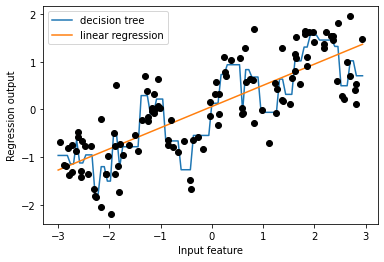

In [ ]:
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 100, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='decision tree')

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label='linear regression')

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.legend(loc='best');

*Comparing linear regression and a decision tree on the `wave` dataset*

* One way to make linear models more powerful on continuous data is to use *binning* (also known as *discretisation*) of the feature to split it up into multiple features.

In [ ]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
print('bin edges: \n', kb.bin_edges_)

bin edges: 
 [array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
       -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
        2.92132162])]


In [ ]:
X_binned = kb.transform(X)
X_binned

<120x10 sparse matrix of type '<class 'numpy.float64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [ ]:
print(X[:10])
X_binned.toarray()[:10]

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]


array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [ ]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)

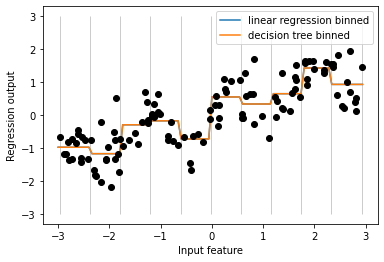

In [ ]:
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')

plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)
plt.legend(loc='best')
plt.ylabel('Regression output')
plt.xlabel('Input feature');

*Comparing linear regression and decision tree regression on binned features*

## 4.5 Interactions and Polynomials

In [ ]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)

(120, 11)


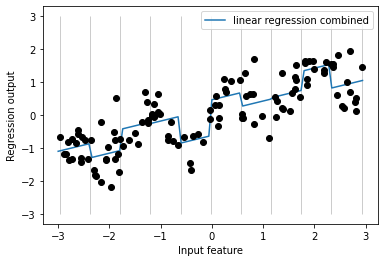

In [ ]:
reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)
plt.legend(loc='best')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.plot(X[:, 0], y, 'o', c='k');

*Linear regression using binned features and a single global point*

In [ ]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

(120, 20)


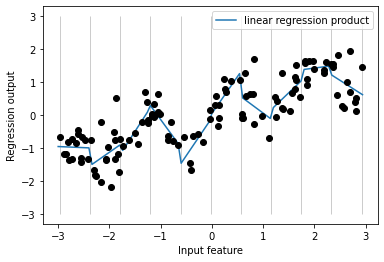

In [ ]:
reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=0.2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.legend(loc='best');

*Linear regression with a separate slope per bin*

In [ ]:
# include polynomials up to x ** 10: the default 'include_bias=True' adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

In [ ]:
print('X_poly.shape: ', X_poly.shape)

X_poly.shape:  (120, 10)


In [ ]:
print('Entries of X:\n{}'.format(X[:5]))
print('Entries of X_poly:\n{}'.format(X_poly[:5]))

Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]


In [ ]:
print('Polynomial feature names:\n{}'.format(poly.get_feature_names_out()))

Polynomial feature names:
['x0' 'x0^2' 'x0^3' 'x0^4' 'x0^5' 'x0^6' 'x0^7' 'x0^8' 'x0^9' 'x0^10']


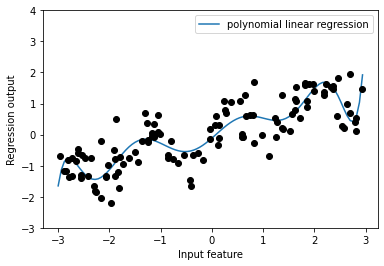

In [ ]:
reg = LinearRegression().fit(X_poly, y)

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylim(-3, 4)
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.legend(loc='best');

*Linear regression with tenth-degree polynomial features*

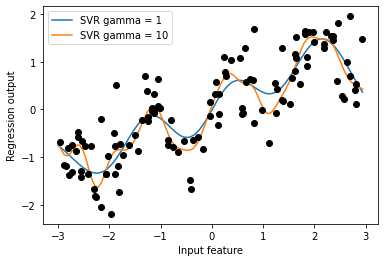

In [ ]:
for gamma in [1, 10]:
    svr = SVR(gamma=gamma).fit(X, y)
    plt.plot(line, svr.predict(line), label='SVR gamma = {}'.format(gamma))

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel('Regression output')
plt.xlabel('Input feature')
plt.legend(loc='best');

*Comparison of different gamma parameters for an SVM with RBF kernel*

In [ ]:
for X_transform_name, X_transform_type in [('X', X), ('X_binned', X_binned), ('X_combined', X_combined), ('X_product', X_product), ('X_poly', X_poly)]:
    print('{} R^2 score: {:.2f}'.format(X_transform_name, LinearRegression().fit(X_transform_type, y).score(X_transform_type, y)))

# Not sure if output of score is accuracy or R^2 (CHECK IN DOCS)
for gamma in [1, 10]:
    print('gamma = {} score: {:.2f}'.format(gamma, SVR(gamma=gamma).fit(X, y).score(X, y)))

X R^2 score: 0.63
X_binned R^2 score: 0.72
X_combined R^2 score: 0.73
X_product R^2 score: 0.79
X_poly R^2 score: 0.73
gamma = 1 score: 0.75
gamma = 10 score: 0.79


**Application on `Boston Housing` dataset**

In [ ]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state=0)

# rescale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
poly = PolynomialFeatures(degree=2).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print('X_train.shape: ', X_train.shape)
print('X_train_poly.shape: ', X_train_poly.shape)

X_train.shape:  (379, 13)
X_train_poly.shape:  (379, 105)


In [ ]:
print('Polynomial feature names:\n{}'.format(poly.get_feature_names_out()))

Polynomial feature names:
['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10' 'x11' 'x12'
 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4' 'x0 x5' 'x0 x6' 'x0 x7' 'x0 x8'
 'x0 x9' 'x0 x10' 'x0 x11' 'x0 x12' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5'
 'x1 x6' 'x1 x7' 'x1 x8' 'x1 x9' 'x1 x10' 'x1 x11' 'x1 x12' 'x2^2' 'x2 x3'
 'x2 x4' 'x2 x5' 'x2 x6' 'x2 x7' 'x2 x8' 'x2 x9' 'x2 x10' 'x2 x11'
 'x2 x12' 'x3^2' 'x3 x4' 'x3 x5' 'x3 x6' 'x3 x7' 'x3 x8' 'x3 x9' 'x3 x10'
 'x3 x11' 'x3 x12' 'x4^2' 'x4 x5' 'x4 x6' 'x4 x7' 'x4 x8' 'x4 x9' 'x4 x10'
 'x4 x11' 'x4 x12' 'x5^2' 'x5 x6' 'x5 x7' 'x5 x8' 'x5 x9' 'x5 x10'
 'x5 x11' 'x5 x12' 'x6^2' 'x6 x7' 'x6 x8' 'x6 x9' 'x6 x10' 'x6 x11'
 'x6 x12' 'x7^2' 'x7 x8' 'x7 x9' 'x7 x10' 'x7 x11' 'x7 x12' 'x8^2' 'x8 x9'
 'x8 x10' 'x8 x11' 'x8 x12' 'x9^2' 'x9 x10' 'x9 x11' 'x9 x12' 'x10^2'
 'x10 x11' 'x10 x12' 'x11^2' 'x11 x12' 'x12^2']


In [ ]:
ridge = Ridge().fit(X_train_scaled, y_train)
print('Score without interactions: {:.2f}'.format(ridge.score(X_test_scaled, y_test)))

ridge = Ridge().fit(X_train_poly, y_train)
print('Score with interactions: {:.2f}'.format(ridge.score(X_test_poly, y_test)))

Score without interactions: 0.62
Score with interactions: 0.75


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100).fit(X_train_scaled, y_train)
print('Score without interactions: {:.2f}'.format(rf.score(X_test_scaled, y_test)))

rf = RandomForestRegressor(n_estimators=100).fit(X_train_poly, y_train)
print('Score with interactions: {:.2f}'.format(rf.score(X_test_poly, y_test)))

Score without interactions: 0.81
Score with interactions: 0.77


## 4.6 Univariate Nonlinear Transformations

In [ ]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)

X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

In [ ]:
print('Number of feature appearances:\n{}'.format(np.sort(np.bincount(X[:, 0]))))

Number of feature appearances:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  5  5  5  5  7  7  8  8  9  9 10 12 14 17 18
 21 21 23 23 23 26 26 27 28 34 35 36 37 38 40 45 48 56 59 61 68]


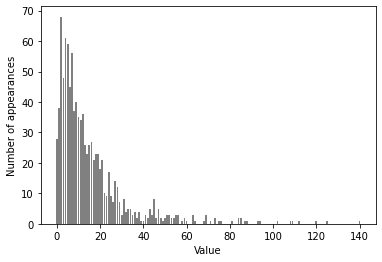

In [ ]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins, color='grey')
plt.ylabel('Number of appearances')
plt.xlabel('Value');

*Histogram of feature values for $X[0]$*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
score = Ridge().fit(X_train, y_train).score(X_test, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.622


In [ ]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

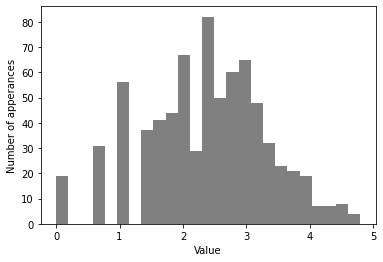

In [ ]:
plt.hist(X_train_log[:, 0], bins=25, color='grey')
plt.ylabel('Number of apperances')
plt.xlabel('Value');

*Histogram of feature values for $X[0]$ after logarithmic transformation*

In [ ]:
score = Ridge().fit(X_train_log, y_train).score(X_test_log, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.875


Binning, polynomials, and interactions can have a huge influence on how models perform on a given dataset. This is particularly true for less complex models like linear models and naive Bayes models. Tree-based models, on the other hand, are often able to discover important interactions themselves, and don't require transforming the data explicity most of the time.

## 4.7 Automatic Feature Selection

### 4.7.1 Univariate Statistics

* Compute whether there is a statistically significant relationship between each feature and the target. Then the features that are related with the highest confidence are selected. In the case of classification, this is also known as *analysis of variance (ANOVA)*.

In [ ]:
cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# add noise features to the data.
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer.target, random_state=0, test_size=0.5)

# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

# transform the training set
X_train_selected = select.transform(X_train)

print('X_train.shape: {}'.format(X_train.shape))
print('X_train_selected.shape: {}'.format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


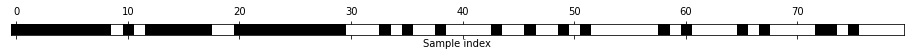

In [ ]:
mask = select.get_support()
print(mask)

#visualise the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')
plt.yticks(());

*Features selected by `SelectPercentile`*

In [ ]:
# transform test data
X_test_selected = select.transform(X_test)
lr = LogisticRegression(solver='lbfgs', max_iter=10000)

lr.fit(X_train, y_train)
print('Score with all features: {:.3f}'.format(lr.score(X_test, y_test)))

lr.fit(X_train_selected, y_train)
print('Score with all features: {:.3f}'.format(lr.score(X_test_selected, y_test)))

Score with all features: 0.951
Score with all features: 0.933


### 4.7.2 Model-Based Feature Selection

In [ ]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42),
                         threshold='median')

In [ ]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)

print('X_train.shape: ', X_train.shape)
print('X_train_l1.shape: ', X_train_l1.shape)

X_train.shape:  (284, 80)
X_train_l1.shape:  (284, 40)


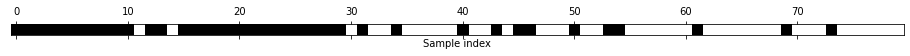

In [ ]:
mask = select.get_support()

# visualise the mask -- black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')
plt.yticks(());

*Features selected by SelectFromModel using the RandomForestClassifier*

In [ ]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train_l1, y_train).score(X_test_l1, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.947


### 4.7.3 Iterative Feature Selection

* **Recursive Feature Elimination (RFE):**
    1. Starts with all features.
    2. Builds a model.
    3. Discards the least important feature according to the model.
    4. Repeat until a prespecified number of features remain.

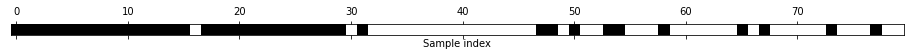

In [ ]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)

# visualise the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel('Sample index')
plt.yticks(());

*Features selected by recursive feature elimination (RFE) with the random forest classifer model*

In [ ]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression(solver='lbfgs', max_iter=10000).fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print('Test score: {:.3f}'.format(score))

Test score: 0.940


In [ ]:
print('Test score: {:.3f}'.format(select.score(X_test, y_test)))

Test score: 0.951


## 4.8 Utilising Expert Knowledge

In [ ]:
citibike = mglearn.datasets.load_citibike()

In [ ]:
print('Citi Bike data:\n{}'.format(citibike.head(5)))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


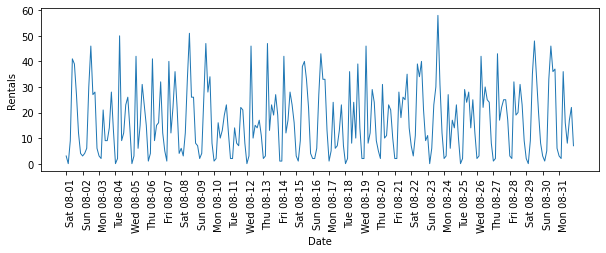

In [ ]:
plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime('%a %m-%d'), rotation=90, ha='left')
plt.plot(citibike, linewidth=1)

plt.xlabel('Date')
plt.ylabel('Rentals');

*Number of bike rentals over time for a selected Citi Bike station*

In [ ]:
# extract the target values (number of rentals)
y = citibike.values

# convert to POSIX time by dividing by 10**9
X = citibike.index.astype('int64').values.reshape(-1, 1) // 10**9

In [ ]:
# use the first 184 data points for training, and the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and test set
    X_train, X_test = features[:n_train], features[n_train:]

    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]

    regressor.fit(X_train, y_train)
    print('Test set R^2: {:.2f}'.format(regressor.score(X_test, y_test)))

    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks.strftime('%a %m-%d'), rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='train')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='test')
    plt.plot(range(n_train), y_pred_train, '--', label='prediction train')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='prediction test')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('Date')
    plt.ylabel('Rentals');

Test set R^2: -0.04


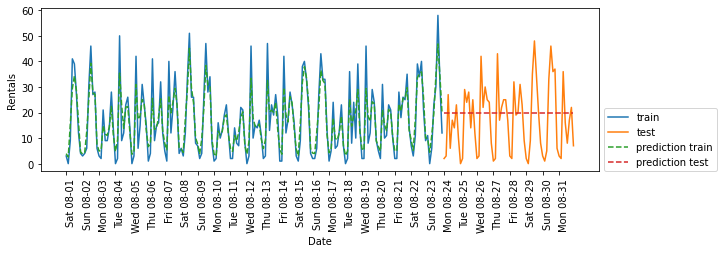

In [ ]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

*Prediction made by a random forest using only the POSIX time*

Test set R^2: 0.60


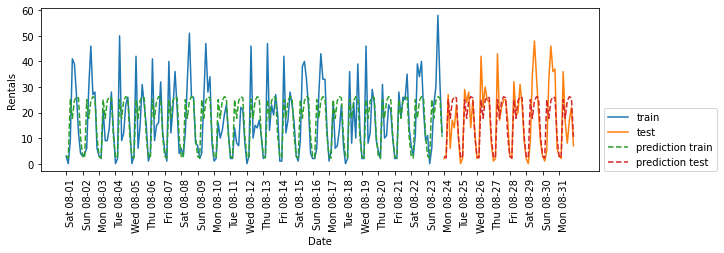

In [ ]:
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

*Predictions made by a random forest using only the hour of the day*

Test set R^2: 0.84


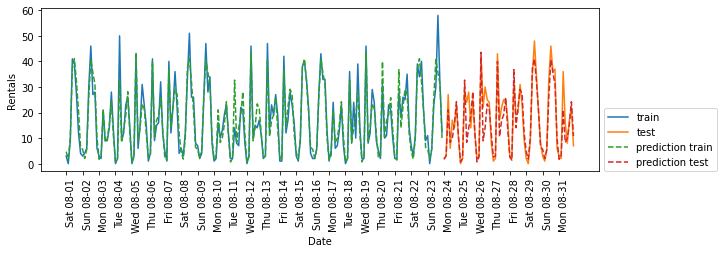

In [ ]:
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])

eval_on_features(X_hour_week, y, regressor)

*Predictions with a random forest using day of week and hour of day features*

Test set R^2: 0.13


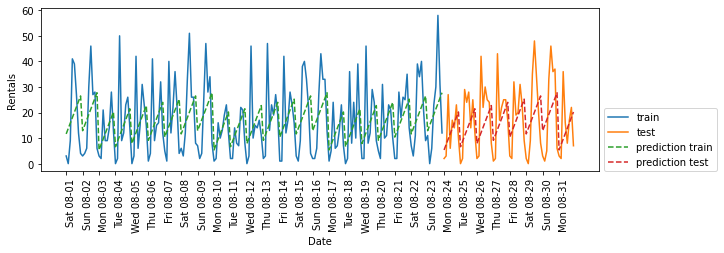

In [ ]:
eval_on_features(X_hour_week, y, LinearRegression())

*Predictions made by linear regression using day of week and hour of day as features*

In [ ]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()

Test set R^2: 0.62


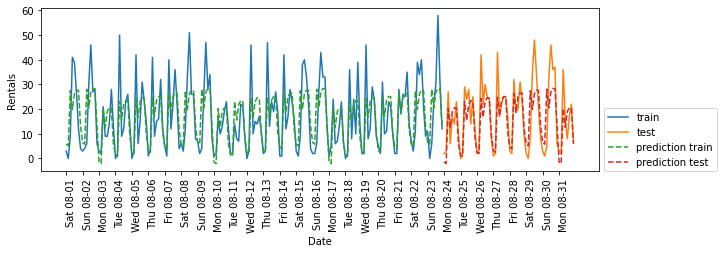

In [ ]:
eval_on_features(X_hour_week_onehot, y, Ridge())

*Predictions made by linear regression using a one-hot encoding of hour of day and day of week*

Test set R^2: 0.85


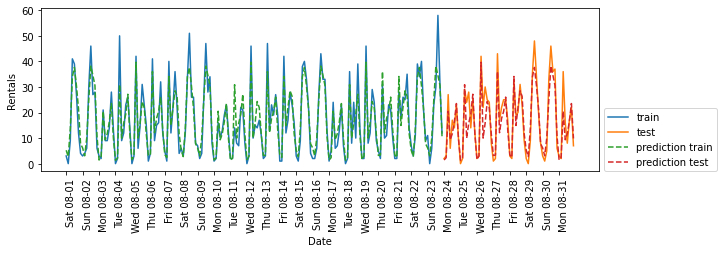

In [ ]:
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)

lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

*Predictions made by linear regression using a product of the day of week and hour of day feature*

In [ ]:
hour = ['%02d:00' % i for i in range(0, 24, 3)]
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

features = day + hour

In [ ]:
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = features_poly[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ != 0]

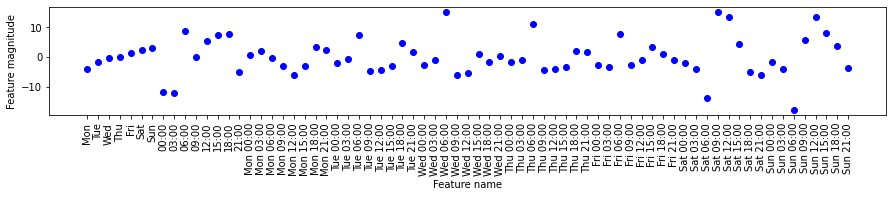

In [ ]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o', color='blue')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel('Feature name')
plt.ylabel('Feature magnitude');

## 4.9 Summary and Outlook

* Important to represent data in a way that is suitable for the machine learning algorithm. E.g., encoding categorical variables.

* Linear models may benefit greatly from generating new features via binning and adding polynomials and interactions.

* More complex models such as random forests and SVMs might be able to learn more complex tasks without explicitly expanding the feature space.